#### NAVIER STOKES EQUATION 2D
Let $\Omega = (-1 , 1)^2$, $\nu > 0$ and $f \in L^2(\Omega)^2, g \in H^{1/2}(\partial\Omega)^2$:

$$
    \begin{cases}
        - \nu \Delta u + (u \cdot \nabla)u + \nabla p &= f  \text{ in } \Omega\\
        \nabla \cdot u &= 0 \text{ in } \Omega\\
        u &= g \text{ on } \partial \Omega\\
        \int_\Omega p dx &= 0
    \end{cases}
$$

#### PDE DATA

$$
    \begin{cases}
        u_1(x, y) &= -sin(\pi x) cos(\pi y),\\
        u_2(x, y) &= cos(\pi x) sin(\pi y),\\
        p(x, y) &= x \exp(\pi y).
    \end{cases}
$$

Thus:

$$
    \begin{split}
        - \nu \Delta u &= 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix},\\
        (u \cdot \nabla)u &= \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix},\\
        \nabla p &= \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}.
    \end{split}
$$

Thus:

$$
    f = 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} + \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix} + \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}.
$$

#### EXPERIMENTS
Experiment 1: $\nu = 0.5$, $p = \infty$;

Experiment 2: $\nu = 0.5$, $p = 2$;

In [1]:
import numpy as np
import sys
import scipy as sp
import torch
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu,\
mui_lp_ext, cart, implicit_euler, L, prepare, extract_models
torch.set_default_dtype(torch.float64)
prefix = None #"nse_2D"

#### CUBATURE AND DIFFERENTIATION

In [2]:
# DOMAIN #
deg_d = [10]*2
cuba_d = Cubature(deg_d, points="Legendre") # for Lobatto points choose points="Lobatto"
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes
bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
dx, dy = diff.nabla
dx2, dy2 = diff.diffs(np.array([[2,0],[0,2]]))

# BOUNDARY #
deg_b = [30]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian([dx, dy], [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian([dx, dy], [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.28581340290223545
0.19552397283234502


#### PDE DATA

In [5]:
nu = 0.5

def gt1(x, y):
    return -np.sin(np.pi*x)*np.cos(np.pi*y)

def gt2(x, y):
    return np.cos(np.pi*x)*np.sin(np.pi*y)

def gt3(x, y):
    return x*np.exp(np.pi*y)

def term1(x, y):
    return np.pi*np.cos(np.pi*x)*np.cos(np.pi*y)

def term2(x, y):
    return np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)

def f1(x, y):
    return (2*nu*np.pi**2-term1(x,y))*gt1(x, y)+\
            term2(x, y)*gt2(x, y)+\
            np.exp(np.pi*y)
            
def f2(x, y):
    return (2*nu*np.pi**2+term1(x,y))*gt2(x, y)-\
            term2(x, y)*gt1(x, y)+\
            np.exp(np.pi*y)*np.pi*x

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

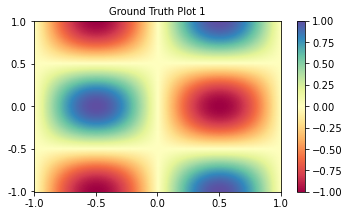

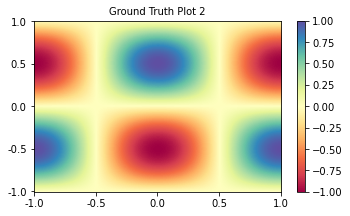

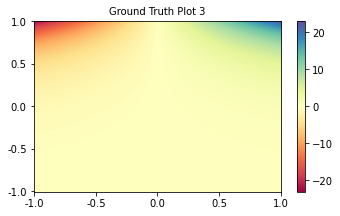

L^2 norm gt1: 0.49999596779071215
L^inf norm gt1: 1.0
L^2 norm gt2: 0.49999596779071215
L^inf norm gt2: 1.0
L^2 norm gt3: 3.8243593463258776
L^inf norm gt3: 23.140692632779267


In [6]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs = [np.linspace(-1.0, 1.0, 249)]*2
data = data_axes(test_xs, mui).T
bm = Benchmark([gt1, gt2, gt3], test_xs, data)
eval_gt = bm.eval_gt()
bm.plot_gt(prefix=prefix)

print(f'L^2 norm gt1: {np.mean(np.array(eval_gt[0])**2)**0.5}')
print(f'L^inf norm gt1: {np.max(abs(np.array(eval_gt[0])))}')

print(f'L^2 norm gt2: {np.mean(np.array(eval_gt[1])**2)**0.5}')
print(f'L^inf norm gt2: {np.max(abs(np.array(eval_gt[1])))}')

print(f'L^2 norm gt3: {np.mean(np.array(eval_gt[2])**2)**0.5}')
print(f'L^inf norm gt3: {np.max(abs(np.array(eval_gt[2])))}')

#### REGRESSION UTILITIES

In [7]:
# leja ordered 2d grid in the domain:
grid_d = cuba_d.leja_grid

# corners:
crnrs = np.array([-1.0, 1.0])

# domain and trace evaluation operators w.r.t. chebyshev polynomials:
C_d = data_axes(xs_d, mui).T
C_b = np.concatenate((
    data_axes([xs_b[0], crnrs], mui).T,
    data_axes([crnrs, xs_b[0]], mui).T,
))

# leja ordered 2d grid on the boundary:
grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs, xs_b[0]])

# ground truth in the first component, evaluated at the boundary:
gt1_b = np.concatenate((
    gt1(grid_b0[:,0], grid_b0[:,1]),
    gt1(grid_b1[:,0], grid_b1[:,1])
))

# ground truth in the second component, evaluated at the boundary:
gt2_b = np.concatenate((
    gt2(grid_b0[:,0], grid_b0[:,1]),
    gt2(grid_b1[:,0], grid_b1[:,1])
))

# functions f1, f2 evaluated within the 2d grid of the domain:
f_1 = f1(grid_d[:,0], grid_d[:,1])
f_2 = f2(grid_d[:,0], grid_d[:,1])

#### MAP TO TENSOR

In [8]:
# Cast data, in order to use the torch autograd library.
f_1 = torch.tensor(f_1)
f_2 = torch.tensor(f_2)
gt1_b = torch.tensor(gt1_b)
gt2_b = torch.tensor(gt2_b)

#### MULTI LSQ FORMULATION

In [9]:
# In the following part, all equations need to have the same input format.
S = dx2 + dy2
equations = np.array([
    lambda u1_d, u2_d, p_d, u1_b, u2_b:-matmul(S, u1_d)+(1/nu)*(u1_d*matmul(dx, u1_d)+u2_d*matmul(dy, u1_d))+(1/nu)*(matmul(dx, p_d)-f_1),\
    lambda u1_d, u2_d, p_d, u1_b, u2_b:-matmul(S, u2_d)+(1/nu)*(u1_d*matmul(dx, u2_d)+u2_d*matmul(dy, u2_d))+(1/nu)*(matmul(dy, p_d)-f_2),\
    lambda u1_d, u2_d, p_d, u1_b, u2_b: matmul(dx, u1_d)+matmul(dy, u2_d),\
    lambda u1_d, u2_d, p_d, u1_b, u2_b: matmul(np.ones_like(W_d), W_d, p_d),\
    lambda u1_d, u2_d, p_d, u1_b, u2_b: u1_b - gt1_b,\
    lambda u1_d, u2_d, p_d, u1_b, u2_b: u2_b - gt2_b])

# _l2 | _ | _s | _mod | _s_mod
metrics = np.array([
    [*[W_d]*4, *[W_b]*2],
    [*[matmul(W_d, M_1)]*2, *[W_d]*2, *[W_b]*2],
    [*[matmul(W_d, M_1_s)]*2, *[W_d]*2, *[W_b]*2],
    [*[matmul(W_d, M_1_mod)]*2, *[W_d]*2, *[n_d*W_b]*2],
    [*[matmul(W_d, M_1_s_mod)]*2, *[W_d]*2, *[n_d*W_b]*2]])

#### TRUNCATION ERROR

In [10]:
# Evaluate all ground truth components, to obtain the truncation error.
gt1_d = torch.tensor(gt1(grid_d[:,0], grid_d[:,1]))
gt2_d = torch.tensor(gt2(grid_d[:,0], grid_d[:,1]))
gt3_d = torch.tensor(gt3(grid_d[:,0], grid_d[:,1]))

# write all arguments in one array
args = [gt1_d, gt2_d, gt3_d, gt1_b, gt2_b]

# _l2 | _ | _s | _mod | _s_mod
trunc_err_arr = [L(args, np.array([equations.T, metrics[i].T]).T)[0].item() for i in range(5)]
trunc_err = {
    "L_l2": trunc_err_arr[0],
    "L_": trunc_err_arr[1],
    "L_s": trunc_err_arr[2],
    "L_mod": trunc_err_arr[3],
    "L_s_mod": trunc_err_arr[4]
}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 0.00011977054466787132,
     "L_": 1.9104752121573334e-06,
     "L_s": 1.7905423770243502e-07,
     "L_mod": 3.1074259277892693e-06,
     "L_s_mod": 1.1112844349251776e-06
}


#### LINEARISATION

It is sufficient to compute the linearisation of the non-linear part, the linearisation of the linear part is:

$$
    T = \begin{bmatrix}
    -\nu \Delta & 0 & \partial_x\\
    0 & -\nu \Delta & \partial_y
    \end{bmatrix}.
$$


Let $u$ and perturbation $\tau v$:

$$
    \begin{split}
        \begin{bmatrix}
            (u_1+\tau v_1) \partial_x(u_1+\tau v_1) + (u_2+\tau v_2) \partial_y (u_1+\tau v_1)\\
            (u_1+\tau v_1) \partial_x(u_2+\tau v_2) + (u_2+\tau v_2) \partial_y (u_2+\tau v_2)
        \end{bmatrix} -
        \begin{bmatrix}
            u_1 \partial_x u_1 + u_2\partial_y u_1\\
            u_1 \partial_x u_2 + u_2 \partial_y u_2
        \end{bmatrix} = 
        \begin{bmatrix} 
            \tau \partial_x(u_1 v_1) + \tau u_2 \partial_y v_1 + \tau v_2\partial_y u_1 + o(\tau)\\
            \tau \partial_x(u_2 v_2) + \tau u_1 \partial_y v_2 + \tau v_1\partial_y u_2 + o(\tau)
        \end{bmatrix}.
    \end{split}
$$

#### SOLUTION

In [11]:
# hyper parameters for implicit euler method:
theta_0 = torch.zeros(3*len(mui))
tau = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
N = 30
print_rate = 5

# define the prepare function (documentation: implicit_euler):
prep = lambda theta: prepare([C_d, 3], [C_b, 3])(theta)[0:5]

# metric (documentation: implicit_euler):
m_l2 = matmul(C_d.T, W_d, C_d)
m_ = matmul(C_d.T, W_d, M_1, C_d)

In [12]:
print(f'cheb_l2:')
cheb_l2, stats_l2 = implicit_euler(
    theta_0,
    m_l2,
    np.array([equations.T, metrics[0].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_l2, indent=5)}')

cheb_l2:
[5]: 1.3216181078496243
[10]: 5.523373646634072e-05
[15]: 5.523048403279596e-05
stats: {
     "iterations": 15,
     "last_loss": 5.523048403279596e-05,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 0.01
}


In [13]:
print(f'cheb_:')
cheb_, stats_ = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[1].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_, indent=5)}')

cheb_:
[5]: 3.4645466789035915
[10]: 1.6374249895676932e-06
[15]: 1.6374249895581192e-06
stats: {
     "iterations": 16,
     "last_loss": 1.637424989558097e-06,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 0.0055
}


In [14]:
print(f'cheb_s:')
cheb_s, stats_s = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[2].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s, indent=5)}')

cheb_s:
[5]: 2.9218960443604205
[10]: 1.0883128558959836e-06
stats: {
     "iterations": 14,
     "last_loss": 1.088312855886955e-06,
     "tau_min": 0.0,
     "tau_max": 1000000.0,
     "tau_median": 0.00055
}


In [15]:
print(f'cheb_mod:')
cheb_mod, stats_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[3].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_mod, indent=5)}')

cheb_mod:
[5]: 7.0361838885768755
[10]: 5.232995762623702e-06
[15]: 5.232995762595642e-06
stats: {
     "iterations": 15,
     "last_loss": 5.232995762595642e-06,
     "tau_min": 0.0,
     "tau_max": 1000.0,
     "tau_median": 0.001
}


In [16]:
print(f'cheb_s_mod:')
cheb_s_mod, stats_s_mod = implicit_euler(
    theta_0,
    m_,
    np.array([equations.T, metrics[4].T]).T,
    prep=prep,
    N=N,
    tau=tau,
    print_rate=print_rate)
print(f'stats: {json.dumps(stats_s_mod, indent=5)}')

cheb_s_mod:
[5]: 7.1177533179927694
[10]: 8.766167753061998e-06
[15]: 8.766167753035427e-06
[20]: 8.766167753032874e-06
stats: {
     "iterations": 20,
     "last_loss": 8.766167753032874e-06,
     "tau_min": 0.0,
     "tau_max": 10000000.0,
     "tau_median": 0.055
}


In [17]:
# SET MODELS #
models_l2 = extract_models(cheb_l2, 3)
models_ = extract_models(cheb_, 3)
models_s = extract_models(cheb_s, 3)
models_mod = extract_models(cheb_mod, 3)
models_s_mod = extract_models(cheb_s_mod, 3)

bm.set_model([*models_l2, *models_, *models_s, *models_mod, *models_s_mod])

#### MODEL EVALUATION AND PLOT

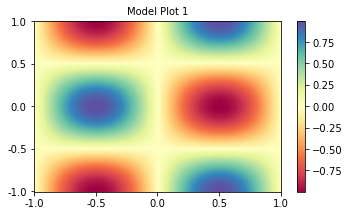

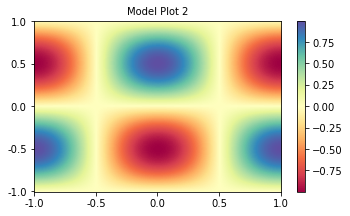

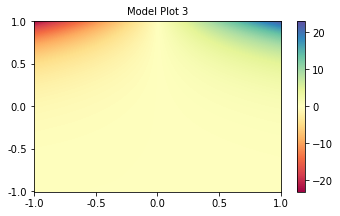

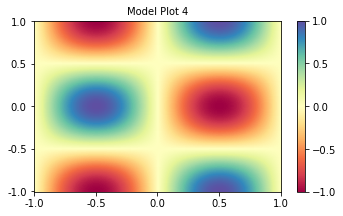

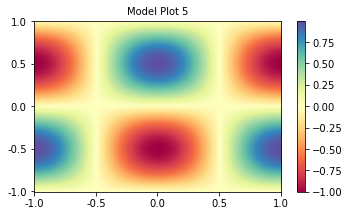

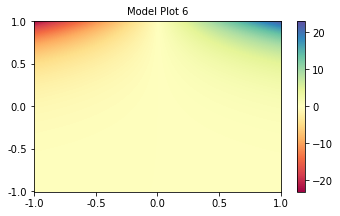

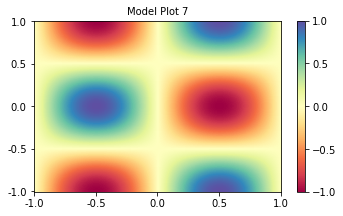

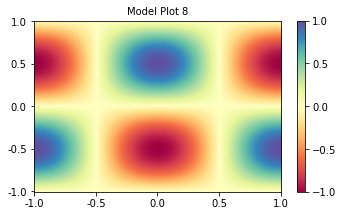

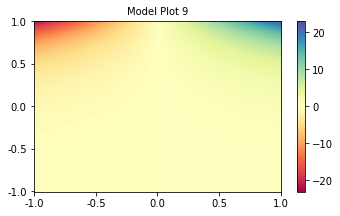

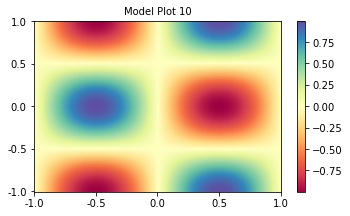

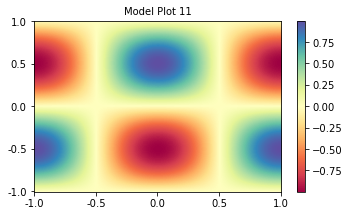

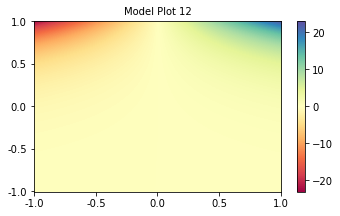

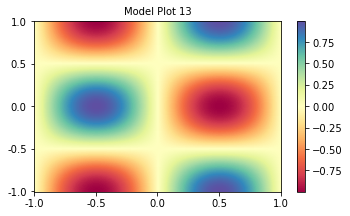

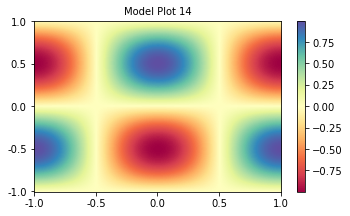

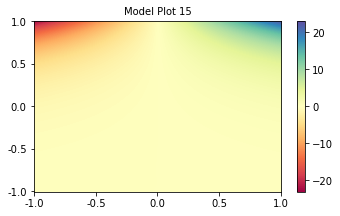

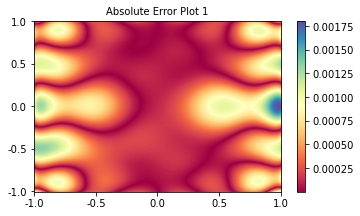

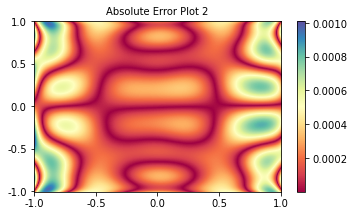

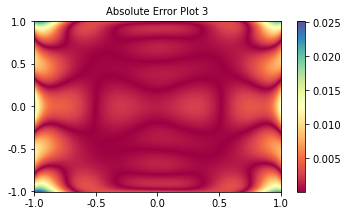

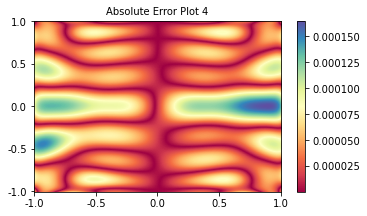

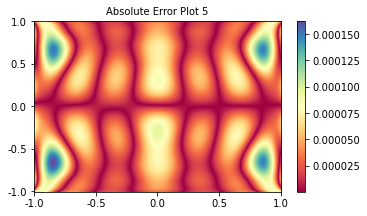

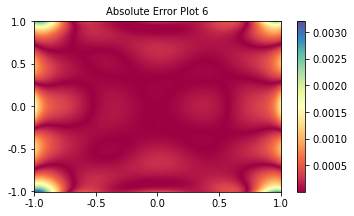

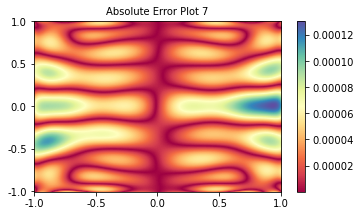

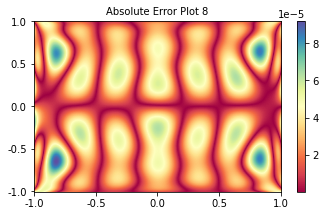

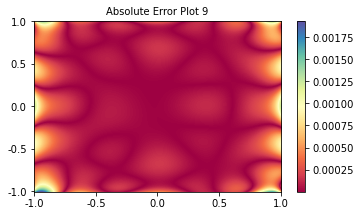

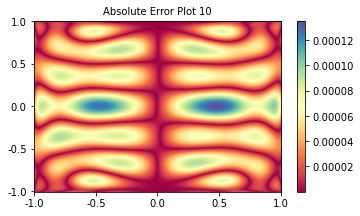

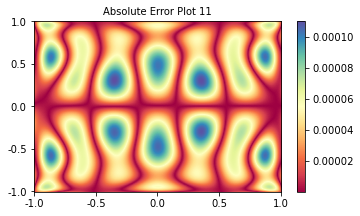

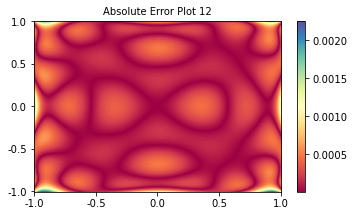

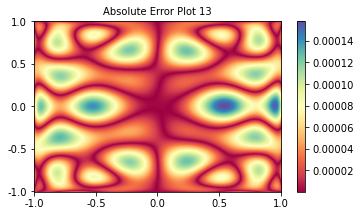

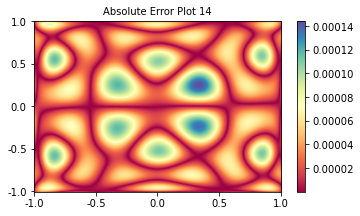

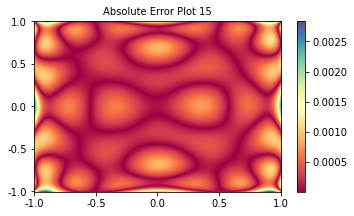

In [18]:
_ = bm.eval_model()
bm.plot_model(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERRORS

In [19]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['3.453e-04', '2.503e-04', '1.96e-03', '4.312e-05', '3.746e-05', '1.903e-04', '3.251e-05', '2.565e-05', '1.345e-04', '3.959e-05', '3.793e-05', '1.904e-04', '4.473e-05', '3.782e-05', '3.406e-04']
L2  Error: 
 ['4.749e-04', '3.202e-04', '3.338e-03', '5.503e-05', '4.799e-05', '3.535e-04', '4.105e-05', '3.108e-05', '2.365e-04', '4.885e-05', '4.655e-05', '2.750e-04', '5.673e-05', '4.789e-05', '4.610e-04']
Max Error: 
 ['1.808e-03', '1.014e-03', '2.528e-02', '1.649e-04', '1.630e-04', '3.214e-03', '1.308e-04', '9.223e-05', '1.937e-03', '1.353e-04', '1.105e-04', '2.263e-03', '1.587e-04', '1.446e-04', '2.848e-03']


#### TABLE FORMAT ERROR

In [20]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[0]} '
err_u_1 = np.array([err[0][0::3],err[1][0::3]])
for _ in err_u_1.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

row = f'{deg_d[0]} '
err_u_2 = np.array([err[0][1::3],err[1][1::3]])
for _ in err_u_2.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

row = f'{deg_d[0]} '
err_p = np.array([err[0][2::3],err[1][2::3]])
for _ in err_p.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'
print(row)

10 & 4.75e-04 & 1.81e-03 & 5.50e-05 & 1.65e-04 & 4.10e-05 & 1.31e-04 & 4.89e-05 & 1.35e-04 & 5.67e-05 & 1.59e-04 \\
10 & 3.20e-04 & 1.01e-03 & 4.8e-05 & 1.63e-04 & 3.11e-05 & 9.22e-05 & 4.66e-05 & 1.11e-04 & 4.79e-05 & 1.45e-04 \\
10 & 3.34e-03 & 2.53e-02 & 3.53e-04 & 3.21e-03 & 2.36e-04 & 1.94e-03 & 2.75e-04 & 2.26e-03 & 4.61e-04 & 2.85e-03 \\
